In [1]:
import pandas as pd

# 读取xlsx格式的文件
df = pd.read_excel('message5299.xlsx')  # 请将'topic.xlsx'替换为您实际的文件名

# 查看数据基本信息
print(df.head())
print(df.info())

                                             content
0  书记：您好。我是2017年博士毕业来深的一名追梦者，2020年博士后出站留深就业，并拿到国自...
1  3月10日实施的人才新政放宽了人才地区与毕业年限的限制，扩大到毕业5年内，现在我这种情况是属...
2  向南方省份学习，由内到外，特别是加大省内市内对人才的发现、挖掘、支持的力度，要以实干为基础，...
3  您好！有以下几个问题：\n1、请问硕士研究生毕业落户苏州有哪些条件要求？\n2、人才引进落户...
4  近些年全国各个城市的人才争夺愈演愈烈，对于竞争力不高的张家口，是不是能出台一些吸引人才，留住...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5299 entries, 0 to 5298
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  5299 non-null   object
dtypes: object(1)
memory usage: 41.5+ KB
None


In [2]:
import jieba
import jieba.analyse
import re

# 加载停用词表
def load_stopwords():
    stopwords = set()
    # 这里可以添加您自己的停用词文件路径
    with open('stopwords_cn.txt', 'r', encoding='utf-8') as f:
        for line in f:
            stopwords.add(line.strip())
    return stopwords

stopwords = load_stopwords()

# 定义文本预处理和分词函数
def preprocess_text(text):
    if isinstance(text, str):
        # 去除特殊字符和数字
        text = re.sub(r'[^\u4e00-\u9fa5]', '', text)
        # 分词
        words = jieba.lcut(text)
        # 去除停用词
        words = [word for word in words if word not in stopwords and len(word) > 1]
        return words
    else:
        return []

# 对所有文本进行预处理
df['tokens'] = df['content'].apply(preprocess_text)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\90346\AppData\Local\Temp\jieba.cache
Loading model cost 0.618 seconds.
Prefix dict has been built successfully.


In [3]:
from gensim import corpora

# 创建词典
dictionary = corpora.Dictionary(df['tokens'])

# 过滤低频和高频词(一个词少于5次出现，一个词占比达50%)
#dictionary.filter_extremes(no_below=5, no_above=0.5)

# 创建语料库
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

In [4]:
from gensim.models import LdaModel

# 设置主题数目K，需要根据困惑度和主题一致性确定最优K值
K = 10  # 初始设定为5，后续可以调整

# 训练LDA模型
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=K, random_state=100, iterations=50, passes=10)

In [5]:
from gensim.models import CoherenceModel, LdaModel
from tqdm import tqdm

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    
    # 使用tqdm创建进度条
    for k in tqdm(range(start, limit, step), desc="计算主题一致性"):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, random_state=100, iterations=50, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values

In [7]:
# 计算不同K值下的主题一致性
start_k = 5
end_k = 15
model_list, coherence_values = compute_coherence_values(dictionary, corpus, df['tokens'], limit=end_k, start=start_k)

计算主题一致性: 100%|█████████████████████████████████████████████████████████████████| 10/10 [28:18<00:00, 169.86s/it]


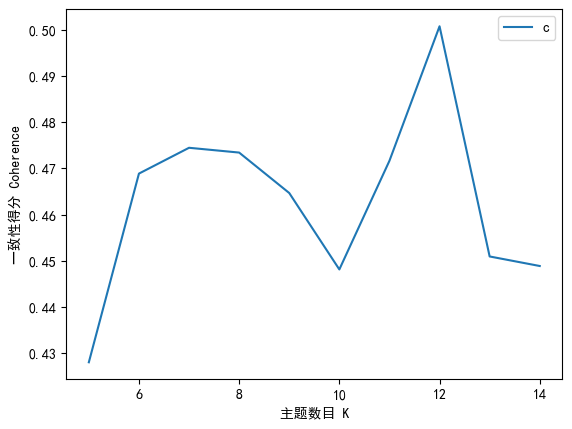

最优主题数目为： 12


In [8]:
# 绘制一致性得分图
import matplotlib.pyplot as plt
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

x = range(start_k, end_k)
plt.plot(x, coherence_values)
plt.xlabel("主题数目 K")
plt.ylabel("一致性得分 Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show()

# 选择一致性得分最高的K值
optimal_k = x[coherence_values.index(max(coherence_values))]
print("最优主题数目为：", optimal_k)

In [9]:
results_df = pd.DataFrame({'K': model_list, 'Coherence_Score': coherence_values})
results_df.to_csv('lda_coherence_scores5299.csv', index=False)
print("一致性得分已导出到 lda_coherence_scores5299.csv")

一致性得分已导出到 lda_coherence_scores24.csv


In [10]:
#使用k=12
optimal_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=12, random_state=100, iterations=50, passes=10)

In [27]:
def print_topics(model, num_topics, num_words):
    for idx, topic in model.print_topics(num_topics=num_topics, num_words=num_words):
        print(f"Topic: {idx+1}")
        print(topic)
        print()

# 打印每个主题的前10个词
print_topics(optimal_model, num_topics=12, num_words=20)

Topic: 1
0.059*"人才" + 0.028*"政策" + 0.020*"落户" + 0.010*"证书" + 0.010*"户口" + 0.010*"购房" + 0.009*"引进" + 0.008*"您好" + 0.007*"购买" + 0.007*"工作" + 0.007*"申请" + 0.007*"条件" + 0.007*"住房" + 0.006*"请问" + 0.006*"咨询" + 0.006*"情况" + 0.006*"办理" + 0.006*"相关" + 0.006*"享受" + 0.005*"子女"

Topic: 2
0.037*"公司" + 0.019*"工资" + 0.017*"人力资源" + 0.012*"小区" + 0.012*"公寓" + 0.010*"业主" + 0.009*"解决" + 0.009*"希望" + 0.009*"离职" + 0.008*"服务" + 0.008*"交房" + 0.008*"项目" + 0.008*"合同" + 0.007*"开发商" + 0.007*"单位" + 0.007*"办理" + 0.006*"人才" + 0.006*"部门" + 0.006*"相关" + 0.006*"拖欠"

Topic: 3
0.046*"人才" + 0.035*"政策" + 0.025*"补贴" + 0.021*"毕业生" + 0.021*"工作" + 0.020*"就业" + 0.018*"毕业" + 0.016*"高校" + 0.013*"申请" + 0.013*"相关" + 0.012*"引进" + 0.010*"您好" + 0.009*"博士" + 0.009*"研究生" + 0.009*"硕士" + 0.008*"享受" + 0.007*"购房" + 0.007*"希望" + 0.007*"社保" + 0.006*"青年"

Topic: 4
0.040*"档案" + 0.015*"市场" + 0.012*"中心" + 0.011*"服务中心" + 0.008*"证明" + 0.008*"学校" + 0.008*"证书" + 0.007*"大连" + 0.006*"存放" + 0.006*"地址" + 0.006*"菏泽" + 0.006*"原件" + 0.005*"体育" + 0.005*"查询" 

In [15]:
topic_weights = optimal_model.get_topic_terms(topicid=0, topn=12)
print(topic_weights)

[(12, 0.05921407), (49, 0.027550837), (144, 0.019623978), (530, 0.010159193), (140, 0.010066411), (80, 0.0096432725), (139, 0.008583869), (43, 0.007947312), (273, 0.0072340444), (166, 0.0069543733), (110, 0.0068576746), (55, 0.0066613667)]


In [17]:



import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pandas as pd

# 假设 optimal_model, corpus, 和 dictionary 已经定义好了

# 准备可视化数据
vis_data = gensimvis.prepare(optimal_model, corpus, dictionary)

# 创建一个主题名称的字典

topic_names = {
    0	: "Topic: 	1	",
    1	: "Topic: 	2	",
    2	: "Topic: 	3	",
    3	: "Topic: 	4	",
    4	: "Topic: 	5	",
    5	: "Topic: 	6	",
    6	: "Topic: 	7	",
    7	: "Topic: 	8	",
    8	: "Topic: 	9	",
    9	: "Topic: 	10	",
    10	: "Topic: 	11	",
    11	: "Topic: 	12	",
  
    # ... 继续为每个主题添加名称
}


# 定义一个安全的获取主题名称的函数
def safe_get_topic_name(x):
    try:
        # 尝试将x转换为整数
        index = int(x)
        # 如果转换成功，使用字典获取名称，如果不存在则使用默认名称
        return topic_names.get(index, f"主题 {index+1}")
    except ValueError:
        # 如果无法转换为整数，直接返回原值的字符串表示
        return str(x)

# 更新主题名称
vis_data.topic_info['topic_label'] = vis_data.topic_info['Category'].apply(safe_get_topic_name)

# 保存为 HTML 文件
pyLDAvis.save_html(vis_data, 'lda_visualization_named12.html')

print("带有自定义主题名称的 LDA 可视化已保存到 lda_visualization_named12.html 文件中。")

带有自定义主题名称的 LDA 可视化已保存到 lda_visualization_named12.html 文件中。


In [20]:
import pandas as pd
import numpy as np

def export_lda_results(lda_model, corpus, dictionary, num_words=10, output_file='lda_results12.csv'):
    # 获取主题-词分布
    topic_word_dist = []
    for i in range(lda_model.num_topics):
        topic_words = lda_model.get_topic_terms(i, topn=num_words)
        words = [dictionary[word_id] for word_id, _ in topic_words]
        weights = [weight for _, weight in topic_words]
        topic_word_dist.append((words, weights))
    
    # 计算主题权重
    topic_weights = np.zeros(lda_model.num_topics)
    for doc in corpus:
        doc_topics = lda_model.get_document_topics(doc)
        for topic, weight in doc_topics:
            topic_weights[topic] += weight
    topic_weights /= len(corpus)
    
    # 创建DataFrame
    df_list = []
    for topic_id, ((words, weights), topic_weight) in enumerate(zip(topic_word_dist, topic_weights)):
        for word, weight in zip(words, weights):
            df_list.append({
                'Topic': topic_id+1,
                'Word': word,
                'Word_Weight': weight,
                'Topic_Weight': topic_weight
            })
    
    df = pd.DataFrame(df_list)
    
    # 保存到CSV
    df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")
    
    return df

# 使用你的模型、语料库和词典
results_df = export_lda_results(optimal_model, corpus, dictionary, num_words=10, output_file='lda_results12.csv')

# 显示结果的前几行
print(results_df.head())

# 额外的分析
print("\n每个主题的权重:")
print(results_df.groupby('Topic')['Topic_Weight'].first().sort_values(ascending=False))

print("\n主题0的前10个词:")
print(results_df[results_df['Topic'] == 0].sort_values('Word_Weight', ascending=False).head(10))

Results saved to lda_results12.csv
   Topic Word  Word_Weight  Topic_Weight
0      1   人才     0.059214      0.134117
1      1   政策     0.027551      0.134117
2      1   落户     0.019624      0.134117
3      1   证书     0.010159      0.134117
4      1   户口     0.010066      0.134117

每个主题的权重:
Topic
3     0.143347
6     0.139162
1     0.134117
7     0.105761
2     0.092153
8     0.075279
12    0.071590
10    0.070660
5     0.066120
9     0.032603
4     0.022787
11    0.018927
Name: Topic_Weight, dtype: float64

主题0的前10个词:
Empty DataFrame
Columns: [Topic, Word, Word_Weight, Topic_Weight]
Index: []


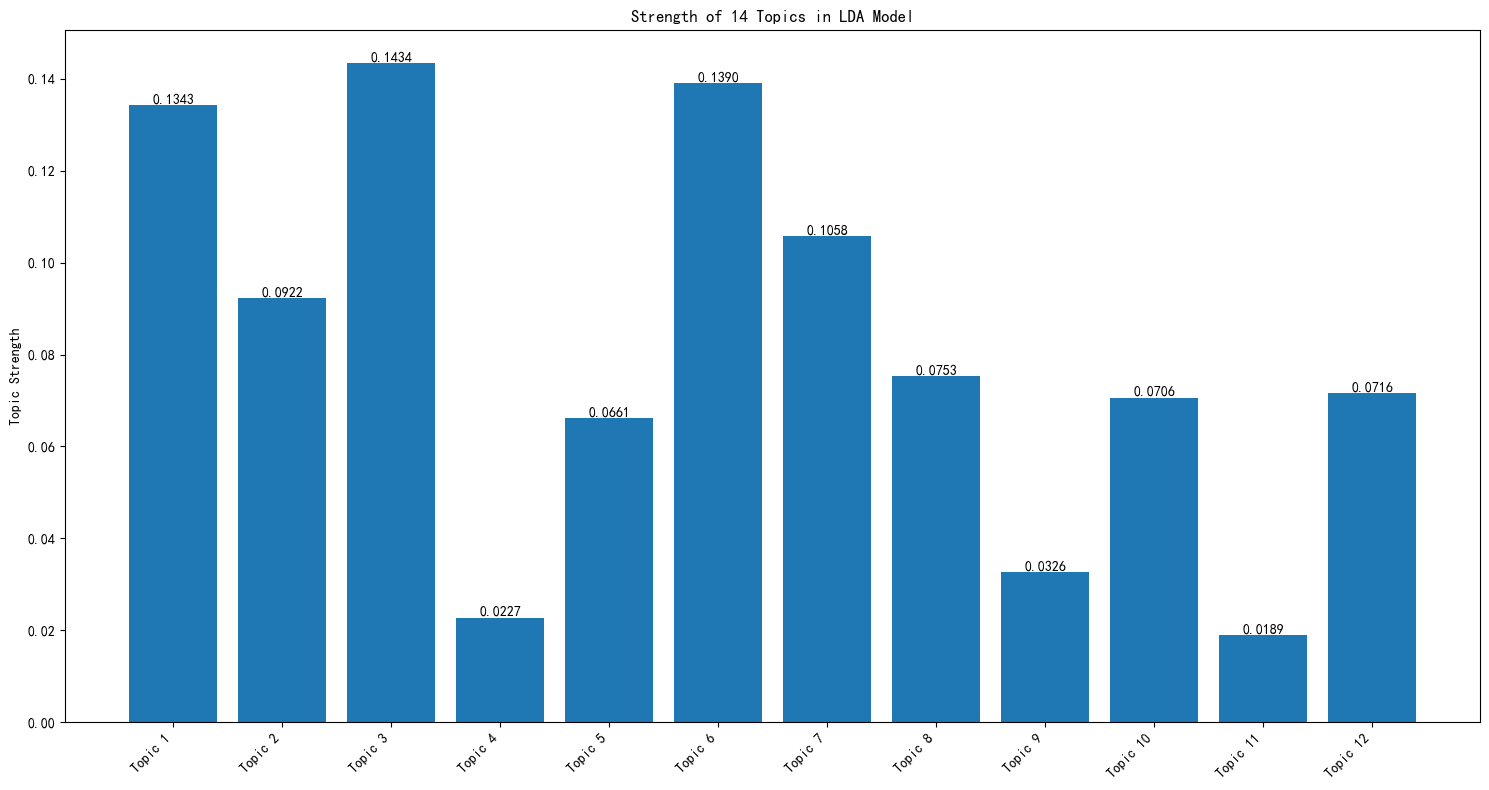

In [19]:
#主题强度分布
import numpy as np
import matplotlib.pyplot as plt

def plot_topic_strengths(lda_model, corpus):
    # 计算每个主题的权重
    topic_weights = np.zeros(lda_model.num_topics)
    for doc in corpus:
        doc_topics = lda_model.get_document_topics(doc)
        for topic, weight in doc_topics:
            topic_weights[topic] += weight
    
    # 归一化权重
    topic_weights /= len(corpus)
    
    # 创建图表
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # 绘制条形图
    bars = ax.bar(range(lda_model.num_topics), topic_weights)
    
    # 设置x轴标签
    ax.set_xticks(range(lda_model.num_topics))
    ax.set_xticklabels([f'Topic {i+1}' for i in range(lda_model.num_topics)], rotation=45, ha='right')
    
    # 设置y轴标签
    ax.set_ylabel('Topic Strength')
    
    # 设置标题
    ax.set_title('Strength of 14 Topics in LDA Model')
    
    # 为每个条形添加数值标签
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', rotation=0)
    
    # 调整布局
    plt.tight_layout()
    
    # 显示图表
    plt.show()

# 使用函数
plot_topic_strengths(optimal_model, corpus)

E:\anaconda\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
E:\anaconda\Lib\site-packages\openpyxl\writer\excel.py:292: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  workbook.properties.modified = datetime.datetime.utcnow()


新文件已保存为 'messagefile_with_topics12.xlsx'
